In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/PetImages.zip","r") as z:
    z.extractall(".")

In [ ]:
import sys
import os
from os import makedirs
from random import seed, random, shuffle
from glob import glob
from os.path import basename, join
from shutil import copyfile, rmtree

from matplotlib import pyplot
from matplotlib.image import imread

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
# define location of dataset
dataset_folder = 'PetImages'

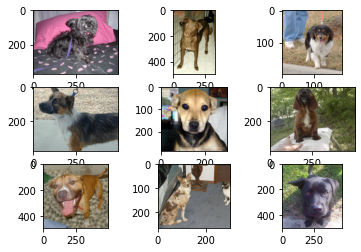

In [ ]:
# plot dog photos from the dogs vs cats dataset

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = join(dataset_folder, 'Dog', str(i) + '.jpg')
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

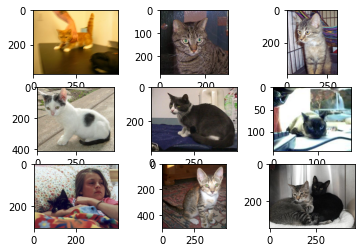

In [ ]:
# plot cat photos from the dogs vs cats dataset

# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = join(dataset_folder, 'Cat', str(i) + '.jpg')
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)

# show the figure
pyplot.show()

In [ ]:
# create label subdirectories

dataset_home = 'dataset_dogs_vs_cats'

#rmtree(dataset_home)

subdirs = ['train', 'test']

labeldirs = ['dogs', 'cats']

for subdir in subdirs:
    for labldir in labeldirs:
        newdir = join(dataset_home, subdir, labldir)
        makedirs(newdir, exist_ok=True)

In [ ]:
# split images

src_files_pattern = join(dataset_folder, '*', '*.jpg')

files = glob(src_files_pattern)

shuffle(files)

# Cut a portion of data
files = files[:1000]

# seed random number generator
seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.3

# copy training dataset images into subdirectories

for file_path in files:
    if random() < val_ratio:
        dst_dir = 'test'
    else:
        dst_dir = 'train'

    if 'Cat' in file_path:
        dst_lbl = 'cats'
    elif 'Dog' in file_path:
        dst_lbl = 'dogs'

    dst_path = join(dataset_home, dst_dir, dst_lbl, basename(file_path))
    copyfile(file_path, dst_path)

In [ ]:
# baseline model for the dogs vs cats dataset

N = 64

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
                     kernel_initializer='he_uniform', padding='same', input_shape=(N, N, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(N, N))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(N, N))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # save model
    model.save('cnn_model.h5')
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

Found 720 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


<ipython-input-9-de01aaa9fdbd>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
<ipython-input-9-de01aaa9fdbd>:55: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 50.357


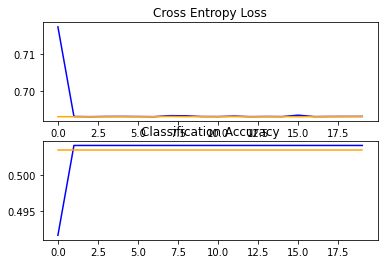

In [ ]:
# entry point, run the test harness
run_test_harness()

In [ ]:
# make a prediction for a new image.

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(N, N))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, N, N, 3)
    img = img.astype('float32') * 1.0/255.0
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('test_dog.jpg')
    # load model
    model = load_model('cnn_model.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])

In [ ]:
!pip install wget
import wget
wget.download("https://petsi.net/images/dogbreed/big/10.jpg", "test_dog.jpg")
wget.download("https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg/1024px-Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg", "test_cat.jpg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'test_cat.jpg'

In [ ]:
# entry point, run the example
run_example()

1/1 [==============================] - 0s 63ms/step
[0.49017513]
